# Bayesian analysis of the empirical saturation point (refactored version)

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

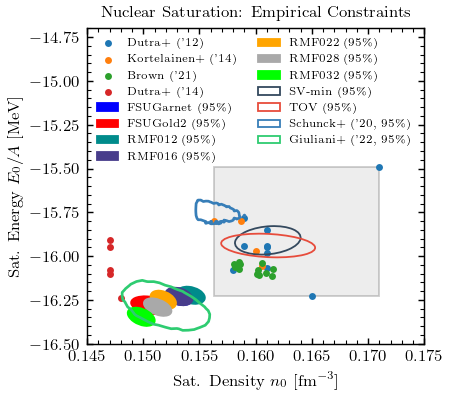

In [2]:
from modules.SaturationAnalysis import SaturationAnalysis
analysis = SaturationAnalysis()
analysis.plot_constraints(eft=False, eft_conf_level=0.95)

## Priors

Let's take a look at the priors used in this work. They can be specified in the file `modules/priors.py`.

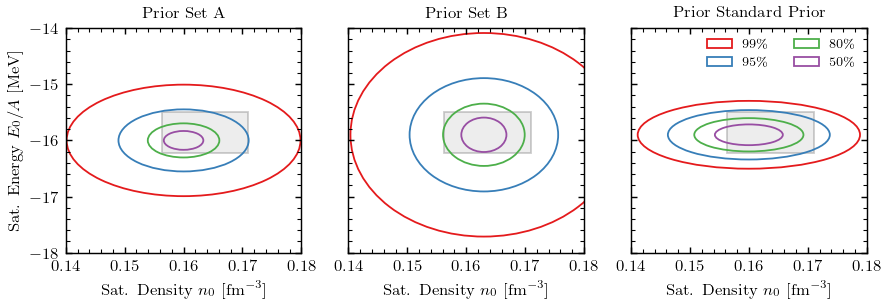

In [3]:
from modules.SaturationAnalysis import visualize_priors
from modules.priors import *
fig, axs = visualize_priors(used_prior_sets)
fig.savefig("pdf/prior_sets.pdf")

We use the two priors on the left to investigate the prior sensitivity of our Bayesian inference.

## Saturation box in Drischler et al. (2016)
### Apply our statistical model directly

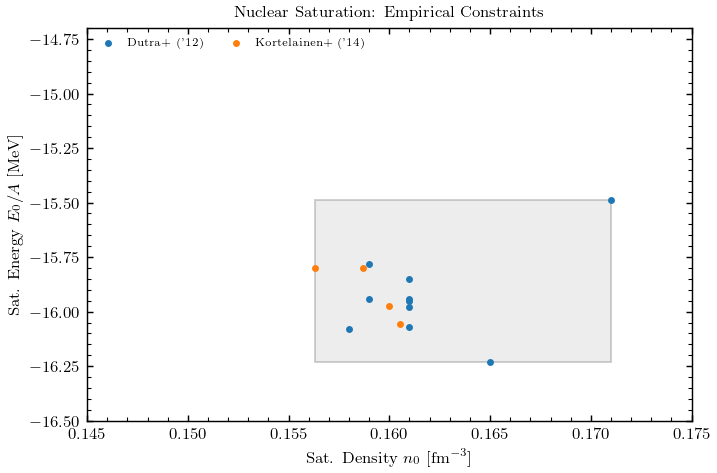

In [5]:
from modules.SaturationAnalysis import drischler_satbox
drischler_satbox.plot(plot_box_estimate=True)

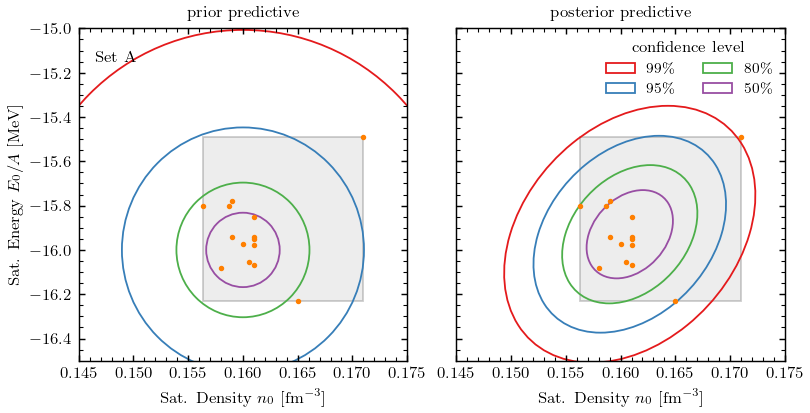

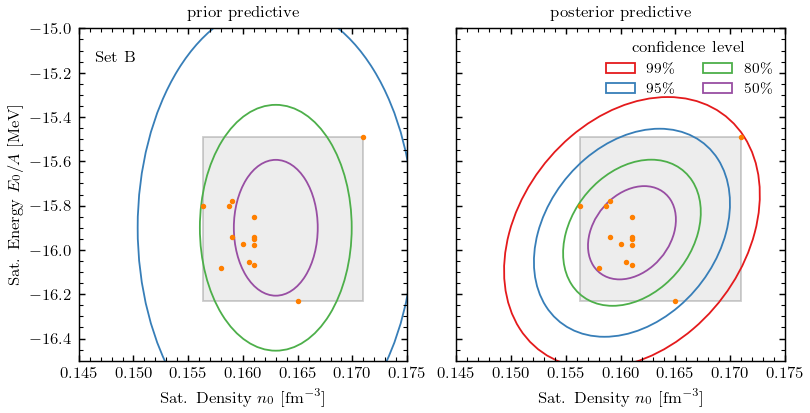

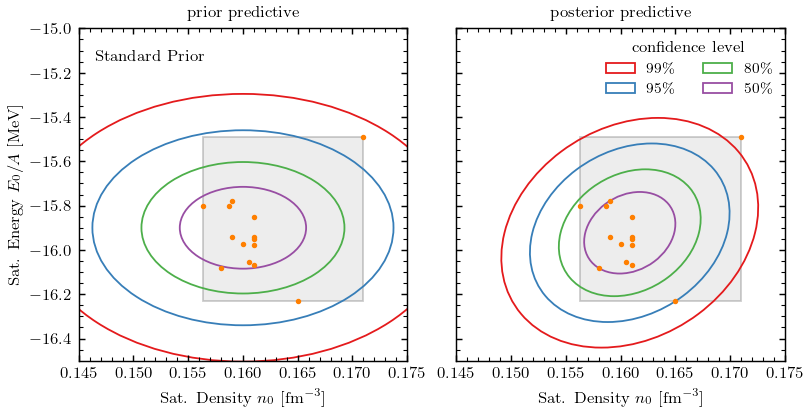

In [6]:
from modules.StatisticalModel import StatisticalModel
for prior_set in used_prior_sets:
    model = StatisticalModel(data=drischler_satbox.data_frame, prior_params=prior_set)
    fig, _ = model.plot_predictives(validate=False)
    fig.savefig(f"overview_analysis_satbox_{label_filename(prior_set['label'])}.pdf")

Set A (17, array([  0.16083667, -15.9292    ]), array([[1.07708821e-05, 1.65382275e-04],
       [1.65382275e-04, 2.74842604e-02]]))
Set B (17, array([  0.16103667, -15.92253333]), array([[1.11649213e-05, 1.64374170e-04],
       [1.64374170e-04, 3.06951362e-02]]))
Standard Prior (23, array([  0.16083667, -15.92253333]), array([[1.21535505e-05, 1.18358879e-04],
       [1.18358879e-04, 2.37265500e-02]]))


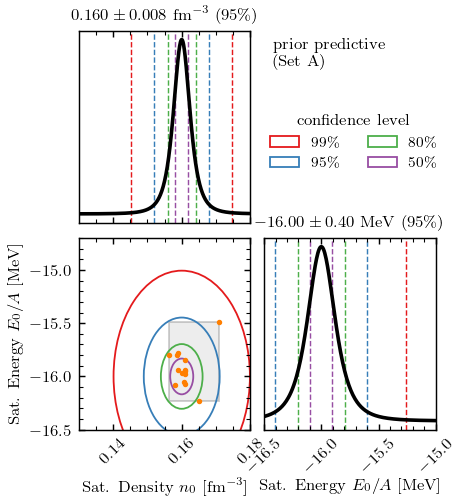

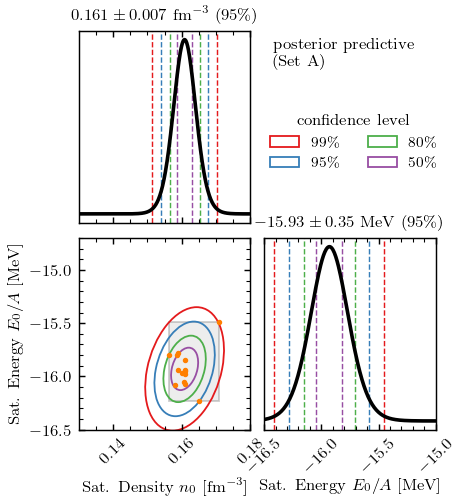

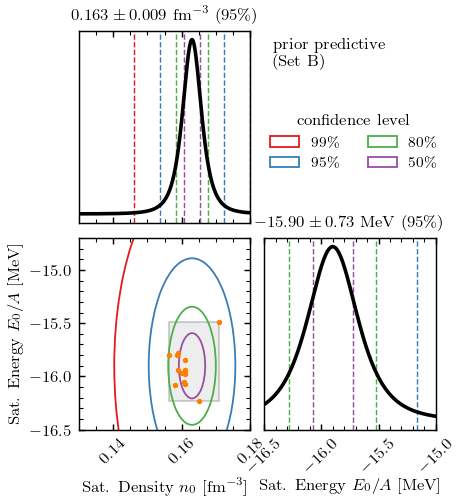

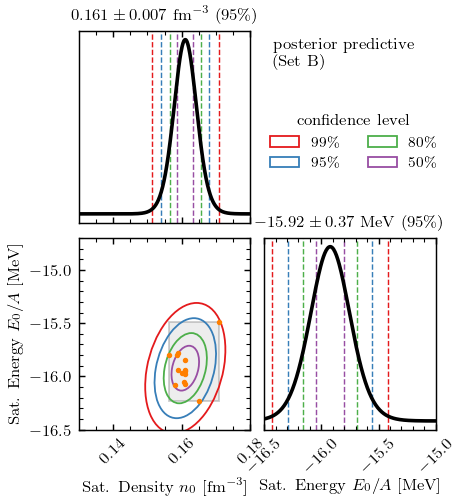

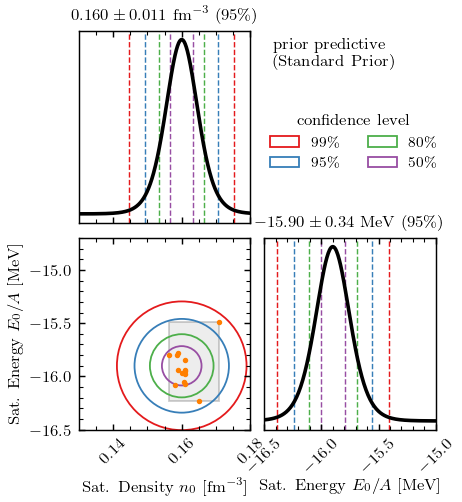

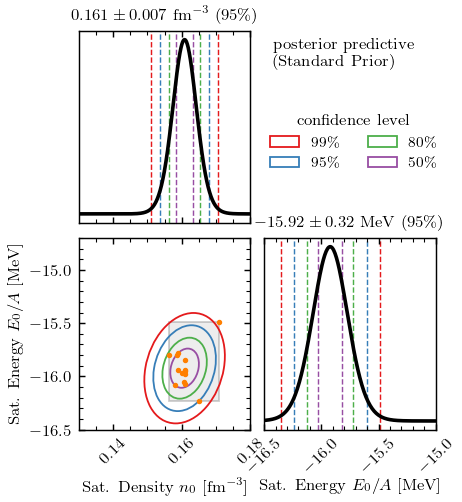

In [7]:
import matplotlib.backends.backend_pdf
for prior_set in used_prior_sets:
    model = StatisticalModel(data=drischler_satbox.data_frame, prior_params=prior_set)
    ret = model.plot_predictives_corner()
    pdf = matplotlib.backends.backend_pdf.PdfPages(f"pdf/corner_plot_{label_filename(prior_set['label'])}.pdf")
    print(prior_set['label'], model.predictives_params())
    for elem in ret:
        fig, axs = elem
        pdf.savefig(fig)
    pdf.close()

Generating the corner plot did not require any sampling of the distribution functions. Only (semi-)analytic calculations. Let's check our implementation brute-force using sampling:

Set A {'kappa': 15, 'nu': 18, 'mu': array([  0.16083667, -15.9292    ]), 'Psi': array([[1.71660933e-04, 2.63578000e-03],
       [2.63578000e-03, 4.38030400e-01]])}
Set B {'kappa': 15, 'nu': 18, 'mu': array([  0.16103667, -15.92253333]), 'Psi': array([[1.77940933e-04, 2.61971333e-03],
       [2.61971333e-03, 4.89203733e-01]])}
Standard Prior {'kappa': 15, 'nu': 24, 'mu': array([  0.16083667, -15.92253333]), 'Psi': array([[2.62060933e-04, 2.55211333e-03],
       [2.55211333e-03, 5.11603733e-01]])}


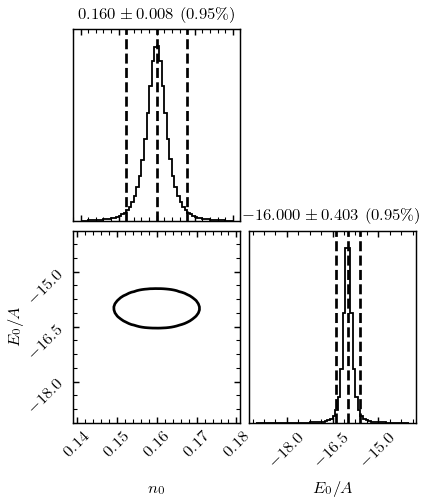

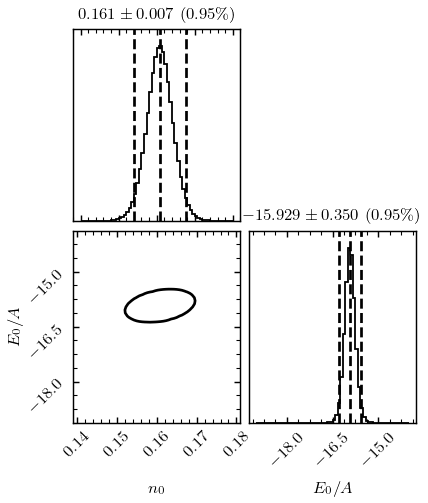

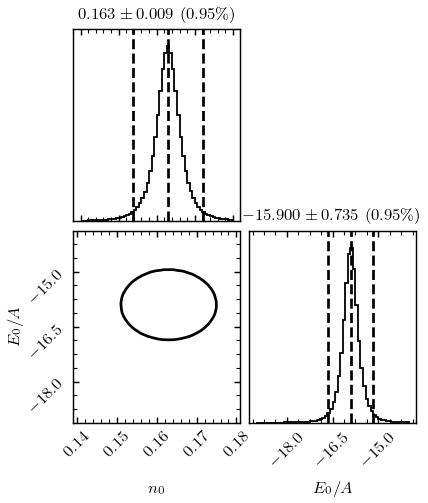

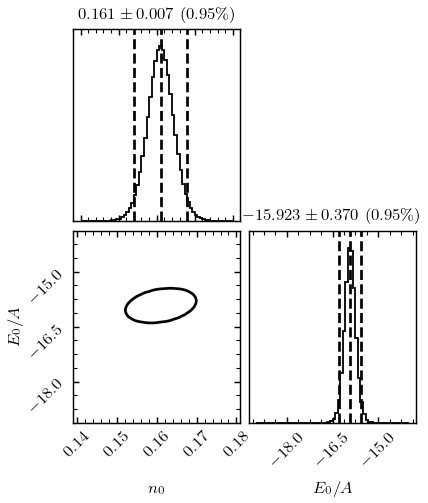

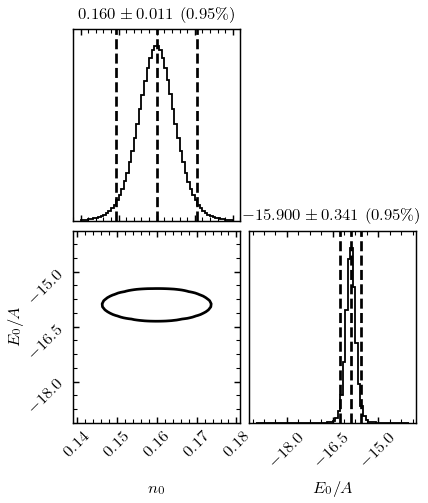

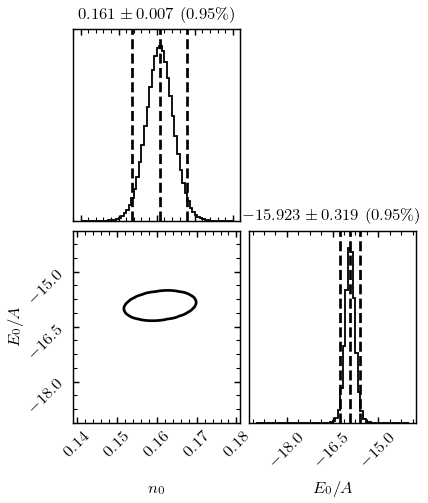

In [8]:
import matplotlib.backends.backend_pdf
for prior_set in used_prior_sets:
    model = StatisticalModel(data=drischler_satbox.data_frame, prior_params=prior_set)
    ret = model.plot_predictives_corner_bf()
    pdf = matplotlib.backends.backend_pdf.PdfPages(f"pdf/corner_plot_bf_{label_filename(prior_set['label'])}.pdf")
    print(prior_set['label'], model.posterior_params)
    for elem in ret:
        fig, axs = elem
        pdf.savefig(fig)
    pdf.close()

The results match. However, the Python package `corner` has a known bug. The percentiles in the titles are always the default ones. We have fixed the issue by computing the percentiles separately. The percentiles above correspond to the 95% confidence level.

### Alternative: use a single Monte Carlo step

In [64]:
from modules.DataSets import Scenario
from modules.SaturationAnalysis import drischler_satbox

scenarioX = Scenario(
    label="Drischler Satbox",
    datasets=[drischler_satbox]
)
npts = len(scenarioX.datasets[0].data_frame)
for prior_set in used_prior_sets:
    fit = analysis.multiverse(
        scenarioX,
        num_realizations=1,
        num_samples_mu_Sigma=10000000,
        num_pts_per_realization=npts,
        sample_replace=False,
        plot_iter_results=False,
        prior_params=prior_set,
        debug=False,
        plot_fitted_conf_regions=True
    )
    print(prior_set["label"], fit)

being MC sampling


MC sampling: 100%|██████████| 1/1 [00:52<00:00, 52.90s/it]


Results written to './pdf/drischler-satbox_set_a_10000000_1.pdf'
Set A {'mu': array([  0.16083529, -15.92926965]), 'Psi': array([[1.07702792e-05, 1.65486004e-04],
       [1.65486004e-04, 2.74884080e-02]]), 'df': 17.0}
being MC sampling


MC sampling: 100%|██████████| 1/1 [00:51<00:00, 51.79s/it]


Results written to './pdf/drischler-satbox_set_b_10000000_1.pdf'
Set B {'mu': array([  0.1610342, -15.9225254]), 'Psi': array([[1.11673775e-05, 1.64275108e-04],
       [1.64275108e-04, 3.06873237e-02]]), 'df': 17.0}
being MC sampling


MC sampling: 100%|██████████| 1/1 [00:51<00:00, 51.77s/it]


Results written to './pdf/drischler-satbox_standard_prior_10000000_1.pdf'
Standard Prior {'mu': array([  0.16083793, -15.92252285]), 'Psi': array([[1.21571323e-05, 1.18088595e-04],
       [1.18088595e-04, 2.37435250e-02]]), 'df': 23.0}


## Hierarchical model

In [4]:
from modules.DataSets import Scenario
from modules.SaturationAnalysis import DEFAULT_DFT_CONSTRAINTS as dft_constraints
scenario1 = Scenario(
    label="FSU-only",
    datasets=[dft_constraints["FSU"]]
)
scenario2 = Scenario(
    label="FSU+Schunck-only",
    datasets=[dft_constraints["FSU"], dft_constraints["Schunck"]]
)
scenario3 = Scenario(
    label="all-but-FSU",
    datasets=[dft_constraints[lbl] for lbl in dft_constraints.keys() if lbl != "FSU"]
)
scenario4 = Scenario(
    label="Giuliani+Schunck-only",
    datasets=[dft_constraints["Giuliani"], dft_constraints["Schunck"]]
)
# scenario1.configs[0].data_set.plot()

In [19]:
for prior_set in used_prior_sets:
    fit = analysis.multiverse(
        scenario3,
        num_realizations=100000,
        num_samples_mu_Sigma=1000,
        num_pts_per_realization=1,
        sample_replace=True,
        plot_iter_results=False,
        prior_params=prior_set,
        debug=False,
        plot_fitted_conf_regions=True,
        parallel_eval=True
    )
    print(prior_set["label"], fit)
    # analysis.plot_individual_models()

Number of workers :  8
+++++343.690517815
Results written to './pdf/all-but-fsu_set_a_1000_100000.pdf'
Set A {'mu': array([  0.15743758, -15.99005575]), 'Psi': array([[2.43580957e-05, 3.47501214e-04],
       [3.47501214e-04, 2.58788757e-02]]), 'df': 9.0}
Number of workers :  8
+++++345.9761996410002
Results written to './pdf/all-but-fsu_set_b_1000_100000.pdf'
Set B {'mu': array([  0.15735902, -15.95877721]), 'Psi': array([[2.69807127e-05, 3.09697790e-04],
       [3.09697790e-04, 2.76079356e-02]]), 'df': 9.0}
Number of workers :  8
+++++362.39944871100033
Results written to './pdf/all-but-fsu_standard_prior_1000_100000.pdf'
Standard Prior {'mu': array([  0.15823859, -15.97570232]), 'Psi': array([[1.95857180e-05, 1.35718120e-04],
       [1.35718120e-04, 2.64425105e-02]]), 'df': 14.0}


## EFT predictions for the nuclear saturation point

In [ ]:
from modules.plot_helpers import cm
import matplotlib.pyplot as plt
from modules.eft_satpoints import make_coester_plot
for prior_set in used_prior_sets:
    fig, ax = plt.subplots(1, 1, figsize=(8.6*cm, 8.6*cm), constrained_layout=True)
    model = StatisticalModel(data=drischler_satbox.data_frame, prior_params=prior_set)
    make_coester_plot(ax,
                      #emp_constraint=drischler_satbox.box_estimate().update({"type": "box"})
                      emp_constraint={"type": "t", **model.predictives_params(return_dict=True)}
                      )
    fig.savefig(f"pdf/eft_satpoints_{label_filename(prior_set['label'])}.pdf")